In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
StartDate = "2017-11-09"
EndDate = "2023-10-17"

df = yf.download("BTC-USD ETH-USD XMR-USD GC=F HG=F ^GSPC", start=StartDate, end=EndDate, group_by='tickers')
df.drop('Adj Close', axis=1, level=1, inplace=True)
df.columns = df.columns.map(' '.join).str.strip(' ')

[*********************100%%**********************]  6 of 6 completed


In [3]:
df_train = df[df.index < pd.to_datetime('2023-09-08')]
df_test = df[(df.index > pd.to_datetime('2023-09-07')) & (df.index < pd.to_datetime('2023-10-09'))]

In [4]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
df_imputed_train = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns, index=df_train.index)
df_imputed_test = pd.DataFrame(imputer.transform(df_test), columns=df_test.columns, index=df_test.index)

In [5]:
df_imputed_concat = pd.concat([df_imputed_train, df_imputed_test])

In [6]:
close_list = ['^GSPC Close', 'HG=F Close', 'GC=F Close', 'XMR-USD Close', 'BTC-USD Close', 'ETH-USD Close']
for cols in close_list:
    col_name = cols.replace(' Close', '')
    df_imputed_concat[f'{col_name} Change'] = df_imputed_concat[cols].diff()
    df_imputed_concat[f'{col_name} Percentage Change'] = df_imputed_concat[cols].pct_change()

    change_up = df_imputed_concat[f'{col_name} Change'].copy()
    change_down = df_imputed_concat[f'{col_name} Change'].copy()
    
    change_up[change_up<0] = 0
    change_down[change_down>0] = 0
    
    avg_up = change_up.rolling(14).mean()
    avg_down = change_down.rolling(14).mean().abs()
    
    df_imputed_concat[f'{col_name} RSI'] = 100 * avg_up / (avg_up + avg_down)
    df_imputed_concat.drop(columns=f'{col_name} Change', inplace=True)

df_imputed_concat['Target'] = df_imputed_concat['XMR-USD Percentage Change'].shift(-1).apply(lambda x: 0 if x < 0 else 1)
df_imputed_concat.dropna(inplace=True)

In [7]:
train = df_imputed_concat[df_imputed_concat.index < pd.to_datetime('2023-09-08')]
test = df_imputed_concat[(df_imputed_concat.index > pd.to_datetime('2023-09-07')) & (df_imputed_concat.index < pd.to_datetime('2023-10-08'))]

In [10]:
if input('Enter 1 to save data to CSV files') == '1':
    train.to_csv('Train.csv')
    test.to_csv('Test.csv')

Data collected and processed

In [12]:
# Prepare data for the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = train.drop(columns='Target')
y = train['Target']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=13)
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_validation = std_scaler.transform(X_validation)

Using RandomForest moodel

In [13]:
# Fit the data
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=1)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       916
           1       1.00      1.00      1.00       987

    accuracy                           1.00      1903
   macro avg       1.00      1.00      1.00      1903
weighted avg       1.00      1.00      1.00      1903

Validation Data
              precision    recall  f1-score   support

           0       0.51      0.49      0.50        91
           1       0.63      0.64      0.64       121

    accuracy                           0.58       212
   macro avg       0.57      0.57      0.57       212
weighted avg       0.58      0.58      0.58       212

Test Data
              precision    recall  f1-score   support

           0       0.50      0.42      0.45        12
           1       0.65      0.72      0.68        18

    accuracy                           0.60        30
   macro avg       0.57      0.57      0.57        30
weighted avg       0.59      0.60 

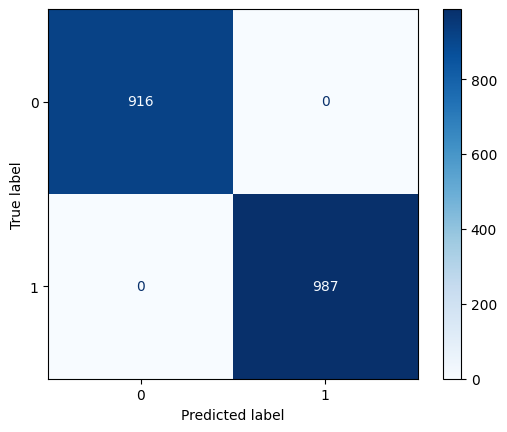

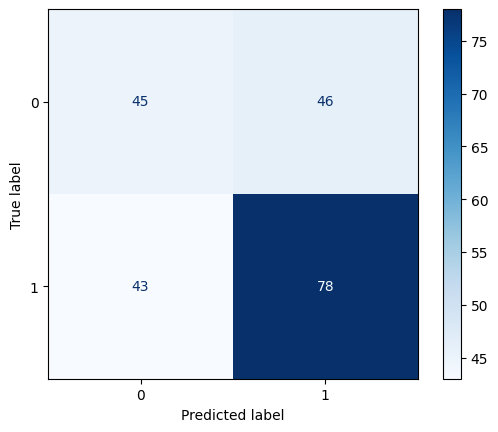

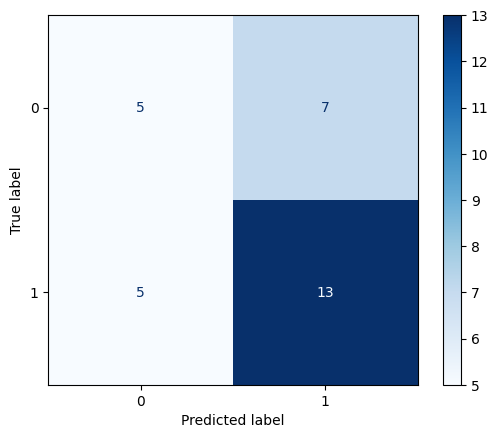

In [14]:
# Training and validation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_train = classifier.predict(X_train)
print(f'Training Data\n{classification_report(y_train, y_pred_train)}')
ConfusionMatrixDisplay.from_estimator(classifier, X_train, y_train, cmap='Blues')
y_pred_validation = classifier.predict(X_validation)
print(f'Validation Data\n{classification_report(y_validation, y_pred_validation)}')
ConfusionMatrixDisplay.from_estimator(classifier, X_validation, y_validation, cmap='Blues')

# test data metrics
X_test = test.drop(columns='Target')
X_test = std_scaler.transform(X_test)
y_test = test['Target']
y_pred_test = classifier.predict(X_test)
print(f'Test Data\n{classification_report(y_test, y_pred_test)}')
print(f'Class 1 predictions : {len(y_pred_test[y_pred_test == 1])}')
print(f'Class 0 predictions : {len(y_pred_test[y_pred_test == 0])}')
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, cmap='Blues');

In [28]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, classification_report
#df to store metrics
metrics_df_valid = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'])
metrics_df_test = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'])


In [29]:
# function to scale the data
def scale(X, Y, Z):
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X)
    X__ = scaler.fit_transform(Y)
    X___ = scaler.fit_transform(Z)
    return X_, X__, X___

#function to get the model parameters
def info(X, Y, model_name, list_name):    
    accuracy = accuracy_score(X, Y)
    precision = precision_score(X, Y)
    recall = recall_score(X, Y)
    f1 = f1_score(X, Y)
    auc = roc_auc_score(X, Y)
    #print
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("AUC-ROC:", auc)
    print(classification_report(X, Y))

    #adding results to the metrics_df
    list_name.loc[len(list_name)] = [model_name, accuracy, precision, recall, f1, auc]
    
    #printing confusion matrix
    confusion_mat = confusion_matrix(X, Y)
    confusion_df = pd.DataFrame(confusion_mat, index=['Actual Negative', 'Actual Positive'],
                             columns=['Predicted Negative', 'Predicted Positive'])
    print(confusion_df)

#function to train the model
def train_model(X, Y, X_test, k=1):
    svm = SVC(kernel='linear',C=k)
    svm.fit(X, Y)
    predicted = svm.predict(X_test)
    return predicted

In [30]:
# Read the data
train = pd.read_csv('./Train.csv')
test = pd.read_csv('./Test.csv')

#converting date to datetime and then converting to integer
train['Date'] = pd.to_datetime(train['Date'])
train['Date'] = train['Date'].astype('int64')

test['Date'] = pd.to_datetime(test['Date'])
test['Date'] = test['Date'].astype('int64')

#trainning data
x_train = train.drop("Target", axis=1)
y_train = train["Target"]

#test data
x_test = test.drop("Target", axis=1)
y_test = test["Target"]

#spliting data into train and validation
X_train, X_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=15)

#scaling the data
X_train_scaled, X_validation_scaled, X_test_scaled = scale(X_train, X_validation, x_test)

Using SVM model

In [31]:
#training the model
#using c = 0.1 as hyperparameter
svm = SVC(kernel='linear',C=0.1)
svm.fit(X_train_scaled, y_train)

SVC(C=0.1, kernel='linear')

In [32]:
#model prediction on validation set
predicted = svm.predict(X_validation_scaled)
info(y_validation, predicted, 'SVM-linear', metrics_df_valid)

print('\n________________________________________________________________\n')

#model prediction on test set
predicted = svm.predict(X_test_scaled)
info(y_test, predicted, 'SVM-linear', metrics_df_test)

Accuracy: 0.5271867612293144
Precision: 0.5214521452145214
Recall: 0.7417840375586855
F1-score: 0.6124031007751939
AUC-ROC: 0.5256539235412475
              precision    recall  f1-score   support

           0       0.54      0.31      0.39       210
           1       0.52      0.74      0.61       213

    accuracy                           0.53       423
   macro avg       0.53      0.53      0.50       423
weighted avg       0.53      0.53      0.50       423

                 Predicted Negative  Predicted Positive
Actual Negative                  65                 145
Actual Positive                  55                 158

________________________________________________________________

Accuracy: 0.6666666666666666
Precision: 0.6818181818181818
Recall: 0.8333333333333334
F1-score: 0.7499999999999999
AUC-ROC: 0.625
              precision    recall  f1-score   support

           0       0.62      0.42      0.50        12
           1       0.68      0.83      0.75        18

 

Using QuadraticDiscriminant model

In [33]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)

predicted = qda.predict(X_validation_scaled)
info(y_validation, predicted, 'QDA', metrics_df_valid)

predicted = qda.predict(X_test_scaled)
info(y_test, predicted, 'QDA', metrics_df_test)

Accuracy: 0.5437352245862884
Precision: 0.5588235294117647
Recall: 0.4460093896713615
F1-score: 0.49608355091383816
AUC-ROC: 0.5444332662642521
              precision    recall  f1-score   support

           0       0.53      0.64      0.58       210
           1       0.56      0.45      0.50       213

    accuracy                           0.54       423
   macro avg       0.55      0.54      0.54       423
weighted avg       0.55      0.54      0.54       423

                 Predicted Negative  Predicted Positive
Actual Negative                 135                  75
Actual Positive                 118                  95
Accuracy: 0.36666666666666664
Precision: 0.4
Recall: 0.1111111111111111
F1-score: 0.1739130434782609
AUC-ROC: 0.4305555555555556
              precision    recall  f1-score   support

           0       0.36      0.75      0.49        12
           1       0.40      0.11      0.17        18

    accuracy                           0.37        30
   macro avg  

using Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

predicted = logreg.predict(X_validation_scaled)
info(y_validation, predicted, 'LogisticRegression', metrics_df_valid)

predicted = logreg.predict(X_test_scaled)
info(y_test, predicted, 'LogisticRegression', metrics_df_test)

Accuracy: 0.4728132387706856
Precision: 0.48188405797101447
Recall: 0.6244131455399061
F1-score: 0.5439672801635992
AUC-ROC: 0.4717303822937625
              precision    recall  f1-score   support

           0       0.46      0.32      0.38       210
           1       0.48      0.62      0.54       213

    accuracy                           0.47       423
   macro avg       0.47      0.47      0.46       423
weighted avg       0.47      0.47      0.46       423

                 Predicted Negative  Predicted Positive
Actual Negative                  67                 143
Actual Positive                  80                 133
Accuracy: 0.6333333333333333
Precision: 0.6666666666666666
Recall: 0.7777777777777778
F1-score: 0.717948717948718
AUC-ROC: 0.5972222222222221
              precision    recall  f1-score   support

           0       0.56      0.42      0.48        12
           1       0.67      0.78      0.72        18

    accuracy                           0.63        30
 

Using AdaBoost

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

base_classifier = LogisticRegression()
adaboost = AdaBoostClassifier(base_estimator=base_classifier)
adaboost.fit(X_train_scaled, y_train)

predicted = adaboost.predict(X_validation_scaled)
info(y_validation, predicted, 'AdaBoost', metrics_df_valid)

print('\n________________________________________________________________\n')

predicted = adaboost.predict(X_test_scaled)
info(y_test, predicted, 'AdaBoost', metrics_df_test)

/Users/rohamizadidoost/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.491725768321513
Precision: 0.4963768115942029
Recall: 0.6431924882629108
F1-score: 0.5603271983640081
AUC-ROC: 0.49064386317907444
              precision    recall  f1-score   support

           0       0.48      0.34      0.40       210
           1       0.50      0.64      0.56       213

    accuracy                           0.49       423
   macro avg       0.49      0.49      0.48       423
weighted avg       0.49      0.49      0.48       423

                 Predicted Negative  Predicted Positive
Actual Negative                  71                 139
Actual Positive                  76                 137

________________________________________________________________

Accuracy: 0.5666666666666667
Precision: 0.631578947368421
Recall: 0.6666666666666666
F1-score: 0.6486486486486486
AUC-ROC: 0.5416666666666666
              precision    recall  f1-score   support

           0       0.45      0.42      0.43        12
           1       0.63      0.67      0.65 

Metrics scores

In [36]:
metrics_df_valid

,Model,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,SVM-linear,0.527187,0.521452,0.741784,0.612403,0.525654
1,QDA,0.543735,0.558824,0.446009,0.496084,0.544433
2,LogisticRegression,0.472813,0.481884,0.624413,0.543967,0.471730
3,AdaBoost,0.491726,0.496377,0.643192,0.560327,0.490644


In [37]:
metrics_df_test

,Model,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,SVM-linear,0.666667,0.681818,0.833333,0.750000,0.625000
1,QDA,0.366667,0.400000,0.111111,0.173913,0.430556
2,LogisticRegression,0.633333,0.666667,0.777778,0.717949,0.597222
3,AdaBoost,0.566667,0.631579,0.666667,0.648649,0.541667


In [38]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.metrics import accuracy_score , f1_score , classification_report , ConfusionMatrixDisplay

In [39]:
X = pd.read_csv("./Train.csv")
y = X['Target']
drops = ['Date' , 'Target'  ]
X = X.drop(columns=drops)
print(X.columns)
X.head()

Index(['GC=F Open', 'GC=F High', 'GC=F Low', 'GC=F Close', 'GC=F Volume',
       'BTC-USD Open', 'BTC-USD High', 'BTC-USD Low', 'BTC-USD Close',
       'BTC-USD Volume', 'HG=F Open', 'HG=F High', 'HG=F Low', 'HG=F Close',
       'HG=F Volume', 'ETH-USD Open', 'ETH-USD High', 'ETH-USD Low',
       'ETH-USD Close', 'ETH-USD Volume', '^GSPC Open', '^GSPC High',
       '^GSPC Low', '^GSPC Close', '^GSPC Volume', 'XMR-USD Open',
       'XMR-USD High', 'XMR-USD Low', 'XMR-USD Close', 'XMR-USD Volume',
       '^GSPC Percentage Change', '^GSPC RSI', 'HG=F Percentage Change',
       'HG=F RSI', 'GC=F Percentage Change', 'GC=F RSI',
       'XMR-USD Percentage Change', 'XMR-USD RSI', 'BTC-USD Percentage Change',
       'BTC-USD RSI', 'ETH-USD Percentage Change', 'ETH-USD RSI'],
      dtype='object')


,GC=F Open,GC=F High,GC=F Low,GC=F Close,GC=F Volume,BTC-USD Open,BTC-USD High,BTC-USD Low,BTC-USD Close,BTC-USD Volume,...,HG=F Percentage Change,HG=F RSI,GC=F Percentage Change,GC=F RSI,XMR-USD Percentage Change,XMR-USD RSI,BTC-USD Percentage Change,BTC-USD RSI,ETH-USD Percentage Change,ETH-USD RSI
0,1636.888798,1644.485999,1629.399932,1636.979985,5438.75,8232.379883,8267.400391,8038.770020,8038.770020,4.225180e+09,...,0.085086,59.565225,0.267405,59.590590,-0.044248,70.415466,-0.026023,60.419049,0.077535,75.929635
1,1286.699951,1286.699951,1286.699951,1286.699951,0.00,8074.020020,8374.160156,7940.930176,8253.690430,5.058610e+09,...,-0.069153,52.534508,-0.213979,50.329646,0.008953,84.513562,0.026735,70.519224,0.157851,90.798317
2,1636.888798,1644.485999,1629.399932,1636.979985,5438.75,8241.709961,8790.919922,8191.149902,8790.919922,4.342060e+09,...,0.074290,50.000000,0.272231,50.000000,0.052585,83.326512,0.065090,78.546026,-0.018182,86.356671
3,1636.888798,1644.485999,1629.399932,1636.979985,5438.75,8789.040039,9522.929688,8775.589844,9330.549805,5.475580e+09,...,0.000000,50.000000,0.000000,50.000000,-0.030088,76.671789,0.061385,88.465261,0.010839,89.518960
4,1293.800049,1293.800049,1293.800049,1293.800049,1.00,9352.719727,9818.349609,9352.719727,9818.349609,5.653320e+09,...,-0.079003,50.587830,-0.209642,50.385842,0.061319,79.881881,0.052280,88.136920,0.019148,89.529949


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
sc = StandardScaler()
sc.fit(X_train)
X_train =sc.transform(X_train)
X_test = sc.transform(X_test)

scaling with standard scaler made the results better and standard scaling was better than min-max sacling

In [41]:
model = KNeighborsClassifier(n_neighbors=60) #f1_score 76
#model = KNeighborsClassifier(p )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6035182679296346
              precision    recall  f1-score   support

           0       0.54      0.38      0.45       312
           1       0.54      0.69      0.60       323

    accuracy                           0.54       635
   macro avg       0.54      0.54      0.53       635
weighted avg       0.54      0.54      0.53       635



Trying knn-method , as expected , knn method score is low

0.5806451612903226
              precision    recall  f1-score   support

           0       0.47      0.67      0.55        12
           1       0.69      0.50      0.58        18

    accuracy                           0.57        30
   macro avg       0.58      0.58      0.57        30
weighted avg       0.60      0.57      0.57        30



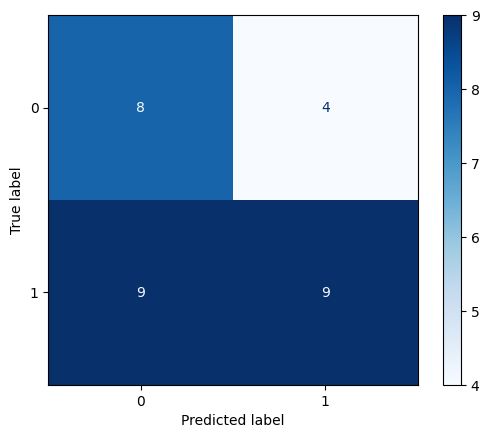

In [43]:
X_Main_test = pd.read_csv('./Test.csv')
y_Main_test = X_Main_test['Target']
X_Main_test = X_Main_test.drop(columns=drops)
X_Main_test = sc.transform(X_Main_test)
y_Main_pred = model.predict(X_Main_test)
print(f1_score(y_Main_test, y_Main_pred))
print(classification_report(y_Main_test, y_Main_pred))
ConfusionMatrixDisplay.from_estimator(model, X_Main_test, y_Main_test, cmap='Blues');


In [44]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss="log_loss" , random_state=41)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test , y_pred))
print(classification_report(y_test, y_pred))

0.5619596541786742
0.521259842519685
              precision    recall  f1-score   support

           0       0.52      0.44      0.47       312
           1       0.53      0.60      0.56       323

    accuracy                           0.52       635
   macro avg       0.52      0.52      0.52       635
weighted avg       0.52      0.52      0.52       635



using sgd method , hyperparameters set

0.7000000000000001
0.6
              precision    recall  f1-score   support

           0       0.50      0.33      0.40        12
           1       0.64      0.78      0.70        18

    accuracy                           0.60        30
   macro avg       0.57      0.56      0.55        30
weighted avg       0.58      0.60      0.58        30



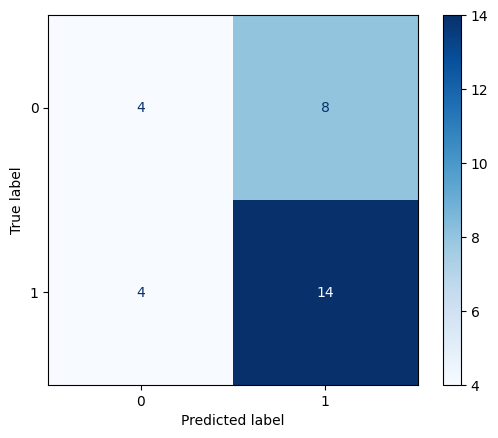

In [45]:
y_Main_pred = model.predict(X_Main_test)
print(f1_score(y_Main_test, y_Main_pred))
print(accuracy_score(y_Main_test , y_Main_pred))
print(classification_report(y_Main_test, y_Main_pred))
ConfusionMatrixDisplay.from_estimator(model, X_Main_test, y_Main_test, cmap='Blues');